# Ejercicio 3

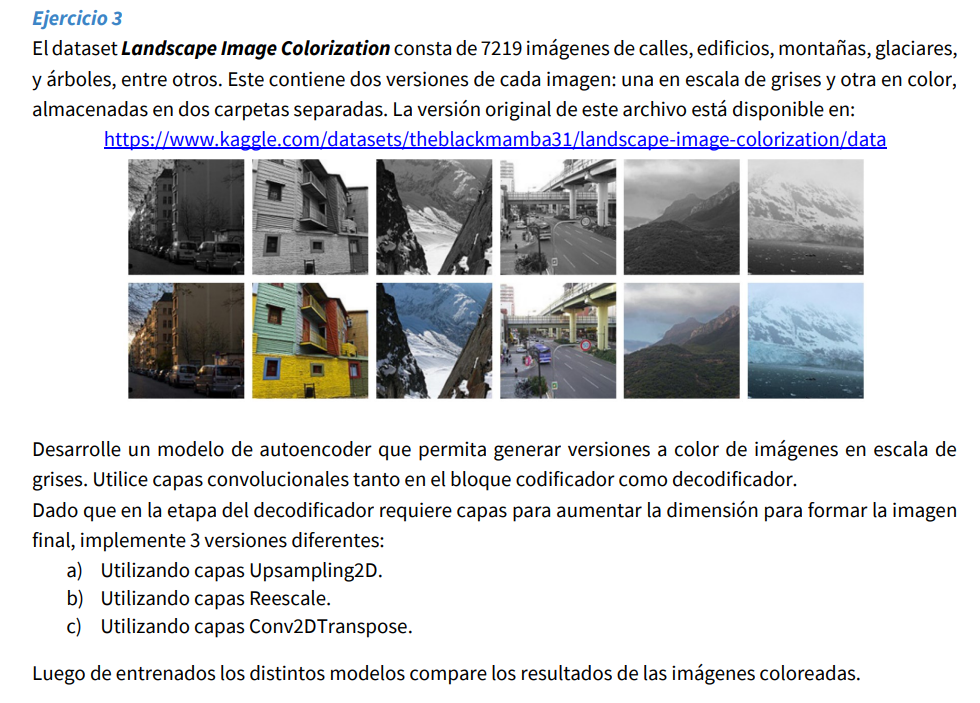

### Importe de librerias y lectura de datos

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
import glob

### Importe de las fotos a color

In [4]:
SIZE = 96  # Tamaño de la imagen que será procesada por la red
color_img = []
gray_img = []

ruta_color = 'C:\\Users\\VICTUS\\Documents\\2024\\Deep_Learning_UNLP\\Datos\\landscape_Images\\color'
ruta_grises = 'C:\\Users\\VICTUS\\Documents\\2024\\Deep_Learning_UNLP\\Datos\\landscape_Images\\gray'

DATOS_LOCAL_DIR = 'C:\\Users\\VICTUS\\Documents\\2024\\Deep_Learning_UNLP\\Datos\\landscape_Images'

archivos = glob.glob('C:\\Users\\VICTUS\\Documents\\2024\\Deep_Learning_UNLP\\Datos\\landscape_Images\\color\\*.jpg')

for ruta_arch in tqdm(archivos):
    # Imagen en color
    img_color = Image.open(ruta_arch)
    img_color = img_color.convert('RGB')  # Convertir a formato RGB si no lo está
    img_color = img_color.resize((SIZE, SIZE))  # Cambiar tamaño
    img_color = np.array(img_color)  # Convertir a arreglo numpy
    img_color = img_color.astype('float32') / 255.0  # Normalizar
    color_img.append(img_color)

    # Imagen en escala de grises
    ruta_gris = ruta_arch.replace('color', 'gray')
    img_gray = Image.open(ruta_gris)
    img_gray = img_gray.resize((SIZE, SIZE))  # Cambiar tamaño
    img_gray = img_gray.convert('RGB')  # Convertir a formato RGB si no lo está
    img_gray = np.array(img_gray)  # Convertir a arreglo numpy
    img_gray = img_gray.astype('float32') / 255.0  # Normalizar
    #img_gray = np.expand_dims(img_gray, axis=-1)  # Agregar dimensión de canal
    gray_img.append(img_gray)

print(img_gray.shape)

100%|██████████| 7129/7129 [01:49<00:00, 64.99it/s]

(96, 96, 3)


Graficos de algunas imagenes

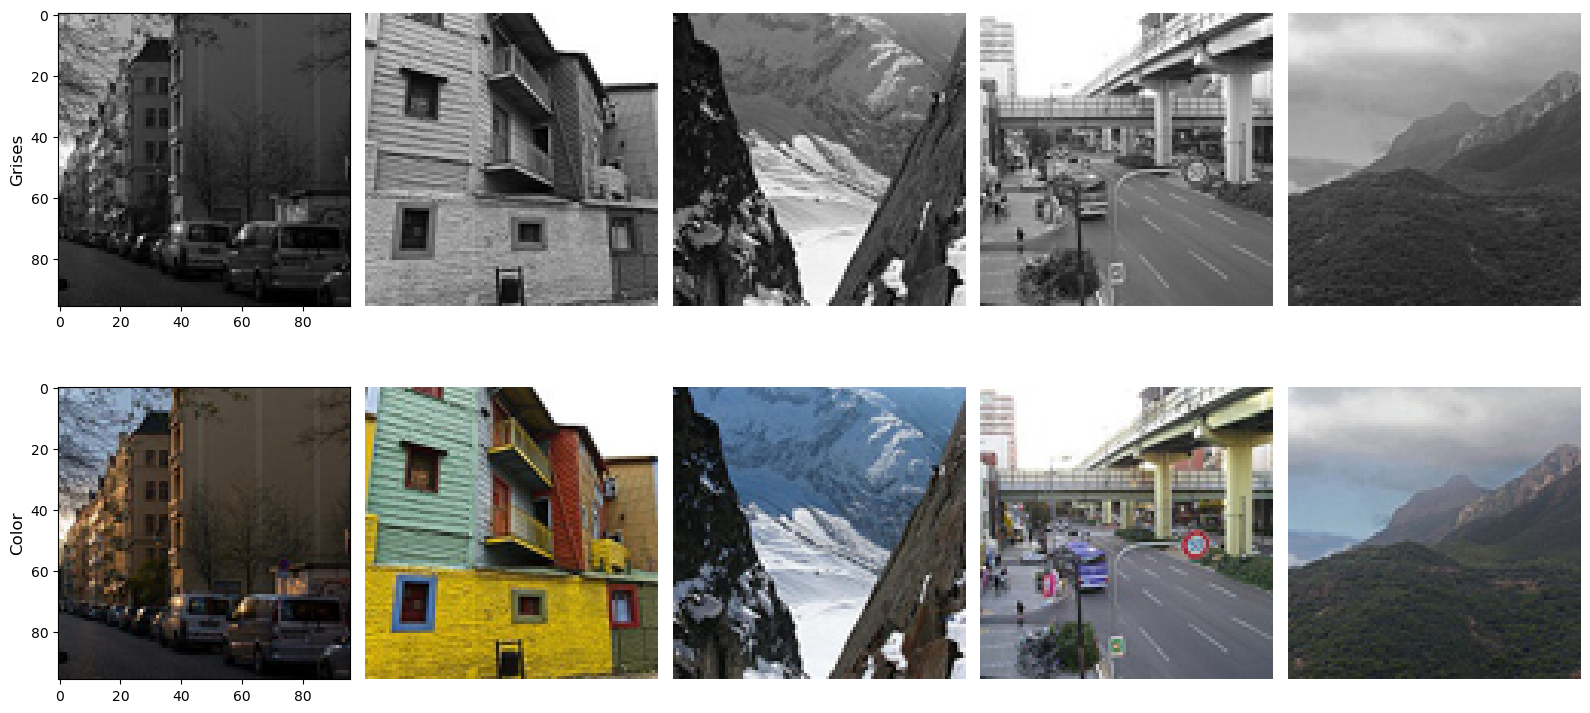

(96, 96, 3)

In [5]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(color_images, grayscale_images, num_images):

    fig, axes = plt.subplots(2, num_images, figsize=(16, 8))

    # Dibujar imágenes en color en la primera fila
    for i in range(num_images):
        axes[0, i].imshow(color_images[i])
        #axes[0, i].set_title('Color Image', color='green', fontsize=12)
        axes[0, i].axis('off')

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_images):
        axes[1, i].imshow(grayscale_images[i], cmap='gray')
        #axes[1, i].set_title('Grayscale Image', color='black', fontsize=12)
        axes[1, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')


    plt.tight_layout()
    plt.show()

plot_images(gray_img, color_img, 5)
gray_img[0].shape

### Separacion en entrenamiento y testeo

In [6]:
NUM_IMGS = len(gray_img)
NUM_TRAIN = int(NUM_IMGS * 0.9)

train_gray_img = gray_img[:NUM_TRAIN]
train_color_img = color_img[:NUM_TRAIN]

test_gray_img = gray_img[NUM_TRAIN:]
test_color_img = color_img[NUM_TRAIN:]

# estructura para dar formato para procesar por la red
train_gray_img = np.reshape(train_gray_img, (-1, SIZE, SIZE, 3))
train_color_img = np.reshape(train_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de entrenamiento:', train_color_img.shape)

test_gray_img = np.reshape(test_gray_img, (len(test_gray_img), SIZE, SIZE, 3))
test_color_img = np.reshape(test_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de prueba.......:', test_color_img.shape)

Shape de imagenes de entrenamiento: (6416, 96, 96, 3)
Shape de imagenes de prueba.......: (713, 96, 96, 3)


### Modelo

In [ ]:
def crear_modelo_conv2D(img_h, img_w, activ='relu'):

    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, 3,))
    encoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same', strides=2)(inputs1)
    encoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same', strides=2)(encoder_output)
    encoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)
    
    decoder_output = layers.Conv2DTranspose(256, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2DTranspose(128, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model


model = crear_modelo_conv2D(SIZE, SIZE, activ='relu')

In [ ]:
def crear_modelo_upsampling(img_h, img_w, activ='relu'):

    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, 3,))
    encoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same', strides=2)(inputs1)
    encoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same', strides=2)(encoder_output)
    encoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
   
    decoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)

    # Reescalado con UpSampling2D en lugar de Conv2DTranspose
    decoder_output = layers.UpSampling2D(size=(2, 2))(decoder_output)  # Aumenta las dimensiones espaciales
    decoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same')(decoder_output)

    decoder_output = layers.UpSampling2D(size=(2, 2))(decoder_output)  # Aumenta las dimensiones espaciales
    decoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same')(decoder_output)

    decoder_output = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model


#model = crear_modelo_upsampling(SIZE, SIZE, activ='relu')

In [ ]:
# la opcion de reescaling no entiendo que capa lleva

In [ ]:
# Compilar y entrenar el modelo utilizando el generador de datos
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='mean_absolute_error')

model.summary()

### Entrenamiento

In [ ]:
model.fit(train_gray_img, train_color_img, epochs = 80, batch_size = 100, verbose = 1)

### Validacion

In [ ]:
model.evaluate(test_gray_img,test_color_img)

### Visualizacion de la prediccion en fotos

In [ ]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_img, color_img, predicted_img, ini_img, num_img):

    fig, axes = plt.subplots(3, num_img, figsize=(14, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_img):
        axes[0, i].imshow(grayscale_img[ini_img+i], cmap='gray')

        axes[0, i].axis('off')

     # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[1, i].imshow(color_img[ini_img+i])
        axes[1, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[2, i].imshow(predicted_img[ini_img+i])
        axes[2, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[2, 0].set_ylabel('Prediccion', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')
    axes[2, 0].axis('on')

    plt.tight_layout()
    plt.show()


ini_imgs = 6
num_imgs = 5

# obtiene imágenes coloreadas del dataset de prueba a partir de imagenes en escala de grises
predicted_img = model.predict(test_gray_img)

plot_images(test_gray_img, test_color_img, predicted_img, ini_imgs, num_imgs)
